
<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Three: Classifier training and performance assessment. </h2>	
Note addtional python code is imported again

In [1]:
from datainput import *
from preprocess import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, KFold, cross_val_score
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


In [2]:
# try not to printout train_data['Pictures'] directly, takes a while
train_path = './20_categories_training/'
train_data = read_train_data(train_path)

## Helper Functions
Functions for train test split and cross validation, as well as functions to calculate accuracies

In [3]:
def train_test_split(df):
    """Split data into training and testing(validation)"""
    n, d = df.shape
    shuffled = np.arange(n)
    np.random.shuffle(shuffled)
    train_n = int(n*0.8)
    test_n = n-train_n
    train_idx = shuffled[:train_n]
    test_idx = shuffled[train_n:]
    return df.iloc[train_idx,:d-1], df.iloc[train_idx,d-1], df.iloc[test_idx,:d-1], df.iloc[test_idx,d-1]

def eval_socre(model, X, y):
    # used for cross validation
    return np.sum(model.predict(X) == y)/len(y)


def custom_cross_validate(df, model, fold = 5, func = eval_socre):
    """find cross validated accuracy scores"""
    # cross validation automatically apply standardscalar
    scalar = StandardScaler()
    pipeline = Pipeline([('transformer', scalar), ('estimator', model)])
    X, y  = df.iloc[:,:-1], df.iloc[:,-1]
    scores = cross_val_score(pipeline, X, y=y, scoring = func, cv = fold)
    return scores

def accuracy(pred, actual):
    return np.sum(pred==actual)/len(pred)


def create_plotting_df(scores, values):
    df = pd.DataFrame()
    for value, score_array in zip(values,scores):
        df = pd.concat([df,pd.DataFrame({'Values':np.ones(len(score_array))*value, 'Scores':score_array})])
    return df

## Convert Original Image DataFrame to Trainable DataFrame

In [4]:
# convert to trainable dataframe
df_X = feature_frame(train_data)

Trim all images..
Processing.. image size
Processing.. aspect ratio
Processing.. red-channel average
Processing.. green-channel average
Processing.. blue-channel average
Processing.. red-channel variance
Processing.. green-channel variance
Processing.. blue-channel variance
Processing.. laplacian average
Processing.. laplacian variance
Processing.. red-channel quantiles
Processing.. green-channel quantiles
Processing.. blue-channel quantiles
Processing.. laplacian quantiles


In [5]:
# split train_data into training and testing
X_train, y_train, X_test, y_test = train_test_split(df_X)

In [6]:
# standardize train test dataset, this train-test set is used for coefficient plotting only
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<h3>  Train models using all of the following methods below. Be sure to drop the actual image column, and the encoding</h3>	Take note of the differences in accuracy, and methods.


## Logistic Regression

In [7]:
# logistic with one over rest scheme
penalties = 10.0**np.arange(-3,5)
scores = []
for c in penalties:
    logistic_model = LogisticRegression(C=c, max_iter=100, solver='liblinear', multi_class='ovr', penalty='l2')
    scores.append(custom_cross_validate(df_X, logistic_model))

temp_ovr = create_plotting_df(scores, penalties)
print('Accuracy:', max([np.mean(x) for x in scores]))

Accuracy: 0.3914003223267282


In [8]:
# multinomial logistic regression
penalties = 10.0**np.arange(-3,5)
scores = []
for c in penalties:
    logistic_model = LogisticRegression(C=c, max_iter=200, solver='newton-cg', multi_class='multinomial')
    scores.append(custom_cross_validate(df_X, logistic_model))

temp_multi = create_plotting_df(scores, penalties)
print('Accuracy:', max([np.mean(x) for x in scores]))

/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


Accuracy: 0.39939755927361875


/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


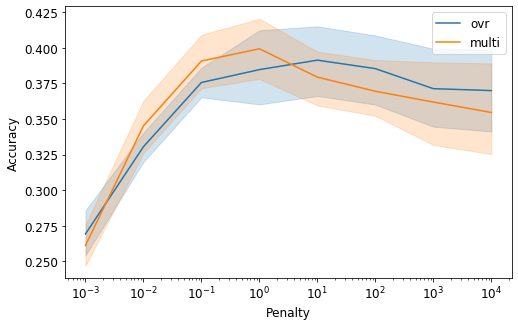

In [9]:
# plot validation set accuracies
plt.rcParams['font.size'] = 12
plt.figure(figsize=(8,5))
sns.lineplot(x = 'Values', y = 'Scores', markers=True, dashes=False, 
             data = temp_ovr, label = "ovr")
sns.lineplot(x = 'Values', y = 'Scores', data = temp_multi, label = "multi")
plt.legend()
plt.xscale('log'), plt.xlabel('Penalty'), plt.ylabel('Accuracy')
plt.savefig('images/logistic')
plt.show()

In [10]:
best_log = LogisticRegression(C=1, max_iter=100, solver='newton-cg', multi_class='multinomial')
best_log.fit(X_train,y_train)
print('Log Reg Accuracy:',accuracy(best_log.predict(X_test), y_test))

Log Reg Accuracy: 0.4485049833887043


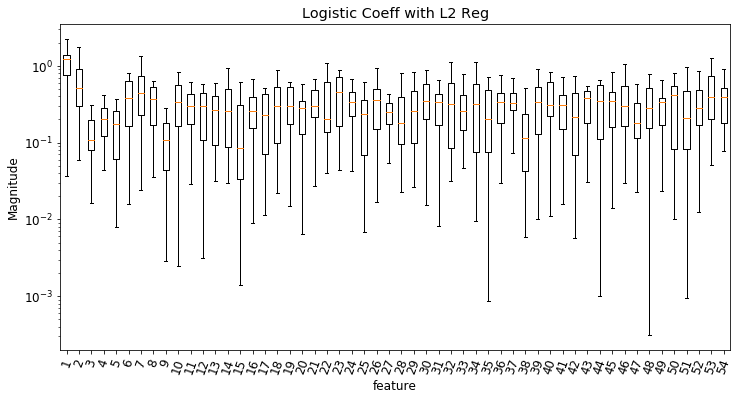

In [11]:
# visualize coefficients from best model
coeffs = np.abs(best_log.coef_)
k, d = coeffs.shape
plt.figure(figsize=(12,6))
plt.boxplot([coeffs[:,i] for i in range(d)], showfliers=False)
plt.yscale('log'), plt.xlabel('feature'), plt.ylabel('Magnitude'), plt.title('Logistic Coeff with L2 Reg')
plt.autoscale(), plt.xticks(rotation=70)
plt.savefig('images/logcoeffs')
plt.show()

## K-nearest Neighbors

In [12]:
neighbors = np.arange(5,50)
scores_d = []
scores_u = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors= i, weights='distance', leaf_size=30)
    scores_d.append(custom_cross_validate(df_X, knn))
    knn = KNeighborsClassifier(n_neighbors= i, weights='uniform', leaf_size=30)
    scores_u.append(custom_cross_validate(df_X, knn))
    
temp_d = create_plotting_df(scores_d, neighbors)
temp_u= create_plotting_df(scores_u, neighbors)


print('Accuracy:', max([np.mean(x) for x in scores_d]))
print('Accuracy:', max([np.mean(x) for x in scores_u]))

Accuracy: 0.33702432549374056
Accuracy: 0.3238031042408715


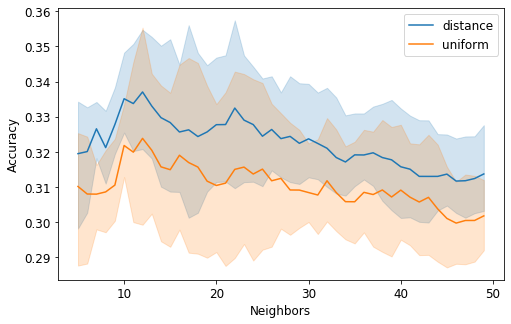

In [13]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'Values', y = 'Scores', data = temp_d, label = "distance")
sns.lineplot(x = 'Values', y = 'Scores', data = temp_u, label = "uniform")

plt.xlabel('Neighbors'), plt.ylabel('Accuracy')
plt.legend()
plt.savefig('images/knn')
plt.show()

## Classification Tree

In [14]:
depths = np.arange(5,20)
scores_t = []
scores_f = []
for depth in depths:
    print(depth,end='..')
    tree_model = DecisionTreeClassifier(max_depth=depth)
    scores_t.append(custom_cross_validate(df_X, tree_model))
    forest_model = RandomForestClassifier(max_depth=depth, n_estimators=100)
    scores_f.append(custom_cross_validate(df_X, forest_model))
print()
temp_t = create_plotting_df(scores_t, depths)
temp_f= create_plotting_df(scores_f, depths)


print('Tree Max CV Accuracy:', max([np.mean(x) for x in scores_t]))
print('Forest Max CV Accuracy:', max([np.mean(x) for x in scores_f]))

5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..
Tree Max CV Accuracy: 0.31436985142286267
Forest Max CV Accuracy: 0.39669542925434087


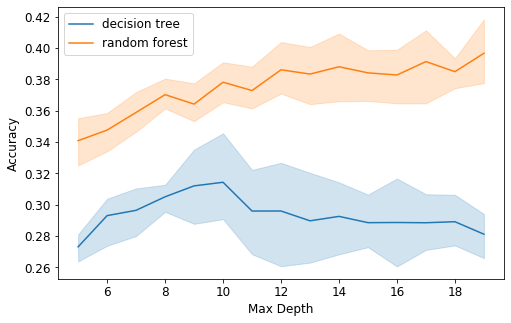

In [15]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'Values', y = 'Scores', data = temp_t, label = "decision tree")
sns.lineplot(x = 'Values', y = 'Scores', data = temp_f, label = "random forest")

plt.xlabel('Max Depth'), plt.ylabel('Accuracy')
plt.legend()
plt.savefig('images/trees')
plt.show()

In [16]:
best_depth = depths[np.argmax([np.mean(x) for x in scores_f])]
best_forest = RandomForestClassifier(max_depth=best_depth, n_estimators=100)
best_forest.fit(X_train, y_train)
print('Forest Accuracy:',accuracy(best_forest.predict(X_test), y_test))

Forest Accuracy: 0.4186046511627907


## Support Vector Machine

In [17]:
penalties = 10.0**np.arange(-3,5)
scores = []
for c in penalties:
    svm_model = LinearSVC(C=c, dual=False, max_iter=2000)
    scores.append(custom_cross_validate(df_X, svm_model))

temp_svm = create_plotting_df(scores, penalties)
print('Accuracy:', max([np.mean(x) for x in scores]))

/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:929: Conver

Accuracy: 0.3982249523938158


/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


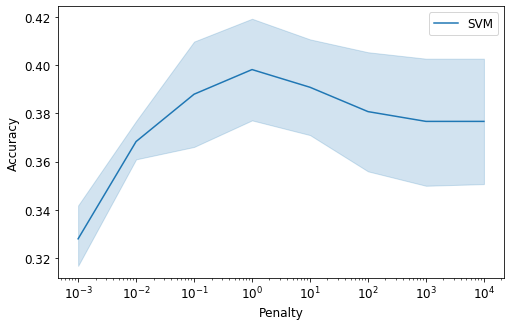

In [18]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'Values', y = 'Scores', data = temp_svm, label = "SVM")
plt.xscale('log'), plt.xlabel('Penalty'), plt.ylabel('Accuracy')
plt.savefig('images/svm')
plt.show()

/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


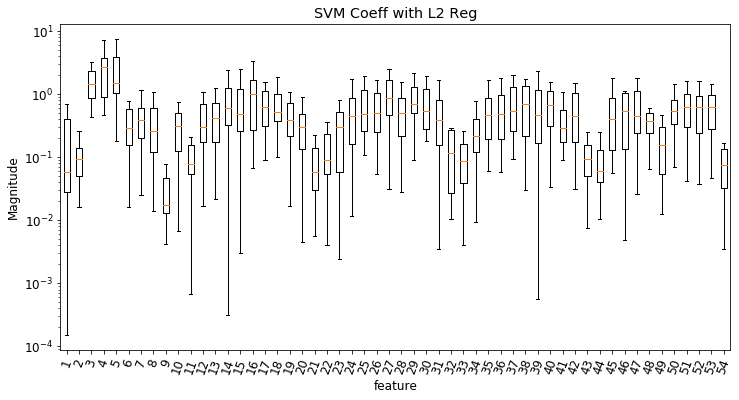

In [19]:
# visualize coefficients
best_model = LinearSVC(C=c, dual=False, max_iter=2000)
best_model.fit(X_train,y_train)
coeffs = np.abs(best_model.coef_)
k, d = coeffs.shape
plt.figure(figsize=(12,6))
plt.boxplot([coeffs[:,i] for i in range(d)], showfliers=False)
plt.yscale('log'), plt.xlabel('feature'), plt.ylabel('Magnitude'), plt.title('SVM Coeff with L2 Reg')
plt.autoscale(), plt.xticks(rotation=70)
plt.savefig('images/svmcoeffs')
plt.show()

## Predict Test Set

In [20]:
val_path = './20_Validation/'
test_data = read_test_data(val_path)

In [24]:
# convert to trainable dataframe
train_df = feature_frame(train_data)
test_df = feature_frame(test_data)

Trim all images..
Processing.. image size
Processing.. aspect ratio
Processing.. red-channel average
Processing.. green-channel average
Processing.. blue-channel average
Processing.. red-channel variance
Processing.. green-channel variance
Processing.. blue-channel variance
Processing.. laplacian average
Processing.. laplacian variance
Processing.. red-channel quantiles
Processing.. green-channel quantiles
Processing.. blue-channel quantiles
Processing.. laplacian quantiles
Trim all images..
Processing.. image size
Processing.. aspect ratio
Processing.. red-channel average
Processing.. green-channel average
Processing.. blue-channel average
Processing.. red-channel variance
Processing.. green-channel variance
Processing.. blue-channel variance
Processing.. laplacian average
Processing.. laplacian variance
Processing.. red-channel quantiles
Processing.. green-channel quantiles
Processing.. blue-channel quantiles
Processing.. laplacian quantiles


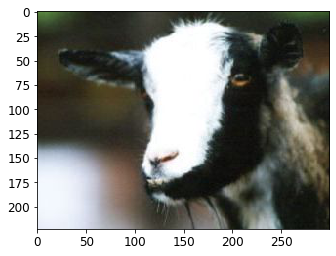

In [25]:
# check order correct
plt.imshow(test_data.iloc[100,0])

In [26]:
# use full training set
ftrain_X, ftrain_y = train_df.iloc[:,:-1], train_df.iloc[:,-1]
scaler = StandardScaler()
scaler.fit(ftrain_X)
ftrain_X = scaler.transform(ftrain_X)
ftest_X = scaler.transform(test_df)

In [27]:
FE = feature_extract()
best_log = LogisticRegression(C=1, max_iter=1000, solver='newton-cg', multi_class='multinomial')
best_log.fit(ftrain_X, ftrain_y)
pred_y = best_log.predict(ftest_X)
# save to csv
final_prediction = pd.DataFrame([FE.labels[x] for x in pred_y])
final_prediction.to_csv('predicted_result.csv', header=False, index=False)